In [1]:
import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scipy.io import loadmat
import hypyp
import mne
import numpy as np

from data_analysis.functions_connectivity import \
    plot_connectivity_matrix
from data_analysis.functions_behavioral import \
    (create_event_df, remove_ghost_triggers, calculate_alpha,
     join_event_dfs, remove_outliers, events_from_event_df)

import matplotlib.pyplot as plt

result_dir = "/net/store/nbp/projects/hyperscanning/study_project/results/"

# BEHAVIOURAL STUFF
import pandas as pd
import glob
from scipy.stats import pearsonr
from matplotlib.pyplot import cm

behav_path = "/net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"

In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /net/store/nbp/projects/hyperscanning/study_project

In [ ]:
# Extract frequency list
freqs = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", str(203) + "_" + "early"))[0].freqs
freqs_list = [round(i,2) for i in freqs]
freqs_list_strings = [str(round(i,2)) for i in freqs]
print(freqs_list)


In [36]:
#subs = ["203"]
subs = ["202", "203", "204", "205", "206", "207", "208", "209", "211", "212"]
cond = "early" 

In [43]:

def plottable_data (subs, cond):

    ispc_list = []
    swi_list = []
    alpha_list = []
    alphalin_list = []
    sub_list = []

    for subj in subs:

        # do the behavioral analysis and get the epochs
        df = pd.read_csv(op.join(behav_path, str(subj) + ".csv"))
        df = calculate_alpha(df)

        # load the eeg based data
        swis = loadmat(op.join(result_dir, "small_worlds", str(subj) + "_" + cond + ".mat"))[cond]
        ispcs = loadmat(op.join(result_dir, "ispc_matrices", str(subj) + "_" + cond + ".mat"))[cond]

        # remove all the trials that were removed by autoreject
        bad_trials = loadmat(op.join(result_dir, "dropped_epochs", str(subj) + ".mat"))["drop_list"][0]
        double_taps = loadmat(op.join(result_dir, "double_taps", str(subj) + ".mat"))["double_taps"][0]

        # remove the epochs marked as bad from autoreject
        df = df[np.logical_not(df["trial"].isin(bad_trials + 1))]

        # add the positive trial indices to remove double taps
        trial_n = np.array([i for i in range(300) if i not in bad_trials]) + 1

        # remove the epochs marked as bad from double taps
        df = df[np.logical_not(df["trial"].isin(double_taps))]
        swis = np.array([vals for trial, vals in zip(trial_n, swis) if trial not in double_taps])
        ispcs = np.array([vals for trial, vals in zip(trial_n, ispcs) if trial not in double_taps])

        trials = set(df["trial"])

        alphas = []
        alphalins = []
        for trial in trials:
            df_filt = df[df["trial"] == trial]

            if cond == "early":
                start = df_filt["ttap"].min()
                stop = start + 1.5
            else:
                stop = df_filt["ttap"].max()
                start = stop - 1.5

            df_frame = df_filt[np.logical_and(df_filt["ttap"] >= start, df_filt["ttap"] <= stop)]
            df_frame = df_frame.dropna()

            alphas.append(df_frame["alpha"].mean())
            alphalins.append(df_frame["alpha_lin"].mean())

        # add them to the lists:
        ispc_list.append(ispcs)
        swi_list.append(swis)
        alpha_list.append(alphas)
        alphalin_list.append(alphalins)
        sub_list.append(subj)

    ispc_list = np.concatenate([i for i in ispc_list], axis=0)
    swi_list = np.concatenate([i for i in swi_list], axis=0)
    alpha_list = np.concatenate([i for i in alpha_list], axis=0)
    alphalin_list = np.concatenate([i for i in alphalin_list], axis=0)
    ispc_inter = ispc_list[:, :64,64:,:]
    ispc_intra = ispc_list[:,64:,:129,:]
    #indices = [idx for idx, val in enumerate(alpha_list) if not np.isnan(val)]

    #ispc_list = ispc_list[indices]
    #swi_list = swi_list[indices]
    #alpha_list = alpha_list[indices]
    #alphalin_list = alphalin_list[indices]




    return ispc_list, swi_list, alphalin_list, ispc_inter, ispc_intra, sub_list


In [45]:
ispc_early, swi_early, alphalin_early, ispc_inter_early, ispc_intra_early,sub_list = plottable_data(subs, "early")

In [46]:
ispc_late, swi_late, alphalin_late, ispc_inter_late, ispc_intra_late, sub_list = plottable_data(subs, "late")

In [39]:
for i in range(len(subs)):
    print(subs[i],"number of ISPC-values:",len(ispc_intra_late[i]))

203 number of ISPC-values: 64


In [48]:
data1 = np.array(ispc_early).flatten()
data2 = np.array(ispc_late).flatten()

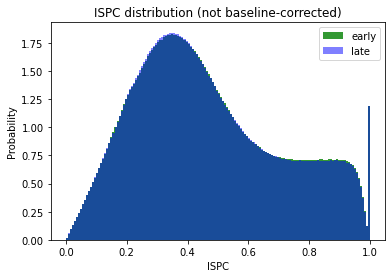

In [50]:
n, bins, patches = plt.hist(data1, 150, density=True, facecolor='g', alpha=0.8, label = 'early')
n, bins, patches = plt.hist(data2, 150, density=True, facecolor='b', alpha=0.5, label = 'late')
plt.title('ISPC distribution (not baseline-corrected)')
plt.ylabel('Probability')
plt.xlabel('ISPC')
plt.legend(loc='upper right')
plt.savefig('ISPC_early_vs_late_hist_203_no_base.pdf')

## ISPC

In [17]:
ispcs_early = []
ispcs_late = []


for subj in subs:
    ispc_sub_early = loadmat(op.join(result_dir, "ispc_matrices", str(subj) + "_" + "early" + ".mat"))["early"]
    ispc_sub_late = loadmat(op.join(result_dir, "ispc_matrices", str(subj) + "_" + "late" + ".mat"))["late"]
    
    ispcs_early.append(ispc_sub_early)
    ispcs_late.append(ispc_sub_late)

In [18]:
data_late = np.array(ispcs_late).flatten()
data_early = np.array(ispcs_early).flatten()

<ipython-input-18-d49f2c95cc4c>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data_late = np.array(ispcs_late).flatten()
<ipython-input-18-d49f2c95cc4c>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data_early = np.array(ispcs_early).flatten()


In [ ]:
n, bins, patches = plt.hist(data_late, 50, density=True, facecolor='g', alpha=0.5, label = 'late')
#n, bins, patches = plt.hist(data_early, 50, density=True, facecolor='b', alpha=0.2, label = 'early')
plt.ylabel('ISPC distribution')
plt.ylabel('Probability')
plt.xlabel('ISPC')
plt.legend(loc='upper right')

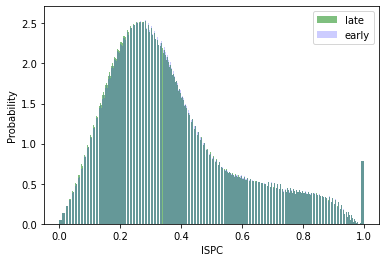

In [19]:
plt.hist(data_late, 100, density=True, facecolor='g', alpha=0.5, label = 'late')
plt.hist(data_early, 100, density=True, facecolor='b', alpha=0.2, label = 'early')
plt.ylabel('ISPC distribution')
plt.ylabel('Probability')
plt.xlabel('ISPC')
plt.legend(loc='upper right')

In [3]:
subj = "204"
cond = "late"
ispcs = loadmat(op.join(result_dir, "ispc_matrices", str(subj) + "_" + cond + ".mat"))[cond]
tfr = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", str(subj) + "_" + cond))[0]
avg_ispcs = np.mean(ispcs, axis=0)
inter_b = [np.mean(avg_ispcs[0:64, 64:2*64, i]) for i in range(len(tfr.freqs))]
intra_b = [np.mean(avg_ispcs[0:64, 0:64, i]) for i in range(len(tfr.freqs))]

Reading /net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/204_late ...


<ipython-input-3-c22199580003>:4: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/204_late) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  tfr = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", str(subj) + "_" + cond))[0]


Not setting metadata


In [7]:
avg_ispcs

array([[[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [0.92708983, 0.91987721, 0.91908314, ..., 0.87726608,
         0.8617406 , 0.8566533 ],
        [0.83066645, 0.8225376 , 0.82202236, ..., 0.72387002,
         0.70323057, 0.68518323],
        ...,
        [0.25484441, 0.24869028, 0.2535134 , ..., 0.267088  ,
         0.25157751, 0.24552493],
        [0.25915778, 0.26424108, 0.26422532, ..., 0.25524556,
         0.25048907, 0.25130594],
        [0.25953706, 0.25858821, 0.26310977, ..., 0.25605954,
         0.25255652, 0.24603959]],

       [[0.92708983, 0.91987721, 0.91908314, ..., 0.87726608,
         0.8617406 , 0.8566533 ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [0.92204946, 0.92186496, 0.92300384, ..., 0.87208678,
         0.87148696, 0.85518664],
        ...,
        [0.25467862, 0.24723918, 0.25372192, ..., 0.26245184,
         0.25387881, 0.24827292],
        [0.2

In [ ]:
def plot_ISPCs(subs, cond):
    for subj in subs:
        ispcs = loadmat(op.join(result_dir, "ispc_matrices", str(subj) + "_" + cond + ".mat"))[cond]
        tfr = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", str(subj) + "_" + cond))[0]
        avg_ispcs = np.mean(ispcs, axis=0)
        inter_b = [np.mean(avg_ispcs[0:64, 64:2*64, i]) for i in range(len(tfr.freqs))]
        intra_b = [np.mean(avg_ispcs[0:64, 0:64, i]) for i in range(len(tfr.freqs))]


    



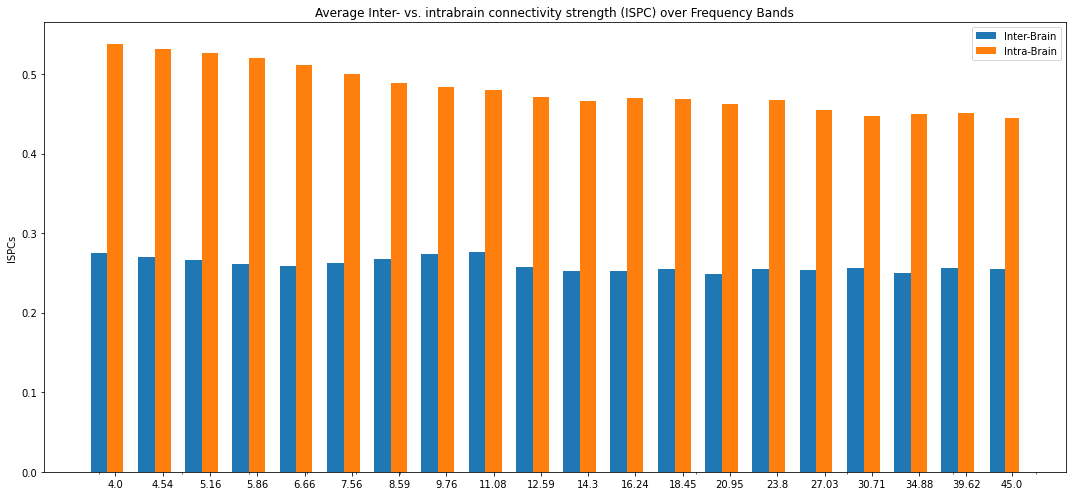

In [17]:
#### x = tfr.freqs  # the label locations
width = np.diff(x) # the width of the bars
width = np.append(width, [5.5], axis = 0)
width /=3

fig, ax = plt.subplots(figsize=(15,7))
rects1 = ax.bar(x - width/2, inter_b, width, label='Inter-Brain',align="edge")
rects2 = ax.bar(x + width/2, intra_b, width, label='Intra-Brain',align="edge")

labels = [str(round(i,2)) for i in tfr.freqs]


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ISPCs')
ax.set_title('Average Inter- vs. intrabrain connectivity strength (ISPC) over Frequency Bands')
ax.set_xscale('log')
ax.set_xticks(x+width)
ax.set_xticklabels(labels)


#ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

#plt.show()
plt.savefig('Avg_ISPC_freqs.pdf')

In [20]:
# do the behavioral analysis and get the epochs
df = pd.read_csv(op.join(behav_path, str(subj) + ".csv"))
df = calculate_alpha(df)

# load the swis
swis = loadmat(op.join(result_dir, "small_worlds", str(subj) + "_" + cond + ".mat"))[cond]

# remove all the trials that were removed by autoreject
bad_trials = loadmat(op.join(result_dir, "dropped_epochs", str(subj) + ".mat"))["drop_list"][0]
double_taps = loadmat(op.join(result_dir, "double_taps", str(subj) + ".mat"))["double_taps"][0]

# remove the epochs marked as bad from autoreject
df = df[np.logical_not(df["trial"].isin(bad_trials + 1))]

# add the positive trial indices to remove double taps
trial_n = np.array([i for i in range(300) if i not in bad_trials]) + 1

# remove the epochs marked as bad from double taps
df = df[np.logical_not(df["trial"].isin(double_taps))]
swis = np.array([vals for trial, vals in zip(trial_n, swis) if trial not in double_taps])

print(len(swis), len(set(df["trial"])))

128 128


In [21]:
df = df.sort_values("trial")

# get the average alpha for early
early_start = df.groupby(["trial"])["ttap"].min()
early_stop = early_start + 1.5

early_avg = []
for start, stop in zip(early_start, early_stop):
    df_filt = df[np.logical_and(df["ttap"] >= start, df["ttap"] <= stop)]
    early_avg.append(df_filt["alpha_lin"].mean())
print(early_stop.shape)

# get the average alpha for late
# same for old
late_stop = df.groupby(["trial"])["ttap"].max()
late_start = late_stop - 1.5

trials = set(df["trial"])

late_avg = []
for trial, start, stop in zip(trials, late_start, late_stop):
    df_filt = df[np.logical_and(df["trial"] == trial , np.logical_and(df["ttap"] >= start, df["ttap"] <= stop))]
    late_avg.append(df_filt["alpha_lin"].mean())
print(late_stop.shape)

(128,)
(128,)


In [22]:
trials = set(df["trial"])

alphas = []
alphalins = []
for trial in trials:
    df_filt = df[df["trial"] == trial]
    
    if cond == "early":
        start = df_filt["ttap"].min()
        stop = start + 1.5
    else:
        stop = df_filt["ttap"].max()
        start = stop - 1.5
        
    df_frame = df_filt[np.logical_and(df_filt["ttap"] >= start, df_filt["ttap"] <= stop)]
    
    alphas.append(df_frame["alpha"].mean())
    alphalins.append(df_frame["alpha_lin"].mean())
    
print(late_stop.shape)


(128,)


In [23]:
df_frame


,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first,diff_inter,diff_intra,alpha,alpha_lin
5384,203,blind,12,300,1,3,4.267664,0.075,1,-0.037352,0.487846,27.563508,27.563508
5385,203,blind,12,300,1,4,4.755510,0.075,1,-0.011429,0.495340,8.306175,8.306175
5393,203,blind,12,300,2,3,4.305016,0.075,1,0.037352,0.461923,29.110380,29.110380
5392,203,blind,12,300,2,2,3.851891,0.075,1,0.037938,0.453125,30.141181,30.141181
5383,203,blind,12,300,1,2,3.813953,0.075,1,-0.037938,0.453711,30.102249,30.102249
5391,203,blind,12,300,2,1,3.334874,0.075,1,-0.033793,0.517017,23.530111,23.530111
5382,203,blind,12,300,1,1,3.368667,0.075,1,0.033793,0.445286,27.320574,27.320574
5394,203,blind,12,300,2,4,4.766939,0.075,1,0.011429,0.445835,9.228479,9.228479


In [24]:
rs = []
for freq in range(swis.shape[-1]):
    r = np.corrcoef(swis[:, freq], early_avg)
    #plt.scatter(swis[:, freq], early_avg)
    #plt.show()
    rs.append(r[0, 1])
rs


[-0.11937838138843265,
 -0.06624170576239657,
 0.01179194711827088,
 0.007814287373382975,
 0.0014758872616903334,
 -0.02397057780508234,
 0.014446010575837304,
 0.003635198751480869,
 0.0783439269118903,
 0.15642808358238658,
 0.09978307492663219,
 -0.01726836187348489,
 -0.11874601306448761,
 -0.10913994886101262,
 -0.07197286890808625,
 0.10107195996484226,
 0.27670687703658847,
 0.10832388343963895,
 -0.08572930358596241,
 0.10563805629315143]

In [25]:
np.corrcoef(np.mean(swis, axis=-1), late_avg)


array([[ 1.        , -0.08113409],
       [-0.08113409,  1.        ]])

[[ 1.         -0.08113409]
 [-0.08113409  1.        ]]


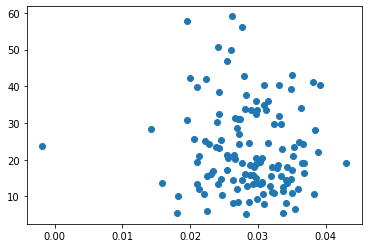

In [26]:
plt.scatter(np.mean(swis, axis=-1), late_avg)
print(np.corrcoef(np.mean(swis, axis=-1), late_avg))


In [27]:
min_idx = event_df.groupby(["trial"])["sample"].idxmin()
early_df = event_df[event_df.index.isin(min_idx)]
early_events = events_from_event_df(early_df)
early_events[:,-1] = 1

# get the late taps by looking at the last sample - 1.5 seconds
max_idx = event_df.groupby(["trial"])["sample"].idxmax()
late_df = event_df[event_df.index.isin(max_idx)]

NameError: name 'event_df' is not defined

### ALL SUBS

In [28]:
import pandas as pd
import glob
from scipy.stats import pearsonr
from matplotlib.pyplot import cm

behav_path = "/net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"

In [29]:
freqs = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", str(203) + "_" + "early"))[0].freqs


Reading /net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/203_early ...


<ipython-input-29-98ae6358c995>:1: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/203_early) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  freqs = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", str(203) + "_" + "early"))[0].freqs


Not setting metadata


In [30]:
freqs
freqs_list = [round(i,2) for i in freqs]
freqs_list_strings = [str(round(i,2)) for i in freqs]
print(freqs_list)

[4.0, 4.54, 5.16, 5.86, 6.66, 7.56, 8.59, 9.76, 11.08, 12.59, 14.3, 16.24, 18.45, 20.95, 23.8, 27.03, 30.71, 34.88, 39.62, 45.0]


In [32]:
def plottable_data (subs, cond):

    ispc_list = []
    swi_list = []
    alpha_list = []
    alphalin_list = []

    for subj in subs:

        # do the behavioral analysis and get the epochs
        df = pd.read_csv(op.join(behav_path, str(subj) + ".csv"))
        df = calculate_alpha(df)

        # load the eeg based data
        swis = loadmat(op.join(result_dir, "small_worlds", str(subj) + "_" + cond + ".mat"))[cond]
        ispcs = loadmat(op.join(result_dir, "ispc_matrices", str(subj) + "_" + cond + ".mat"))[cond]

        # remove all the trials that were removed by autoreject
        bad_trials = loadmat(op.join(result_dir, "dropped_epochs", str(subj) + ".mat"))["drop_list"][0]
        double_taps = loadmat(op.join(result_dir, "double_taps", str(subj) + ".mat"))["double_taps"][0]

        # remove the epochs marked as bad from autoreject
        df = df[np.logical_not(df["trial"].isin(bad_trials + 1))]

        # add the positive trial indices to remove double taps
        trial_n = np.array([i for i in range(300) if i not in bad_trials]) + 1

        # remove the epochs marked as bad from double taps
        df = df[np.logical_not(df["trial"].isin(double_taps))]
        swis = np.array([vals for trial, vals in zip(trial_n, swis) if trial not in double_taps])
        ispcs = np.array([vals for trial, vals in zip(trial_n, ispcs) if trial not in double_taps])

        trials = set(df["trial"])

        alphas = []
        alphalins = []
        for trial in trials:
            df_filt = df[df["trial"] == trial]

            if cond == "early":
                start = df_filt["ttap"].min()
                stop = start + 1.5
            else:
                stop = df_filt["ttap"].max()
                start = stop - 1.5

            df_frame = df_filt[np.logical_and(df_filt["ttap"] >= start, df_filt["ttap"] <= stop)]
            df_frame = df_frame.dropna()

            alphas.append(df_frame["alpha"].mean())
            alphalins.append(df_frame["alpha_lin"].mean())

        # add them to the lists:
        ispc_list.append(ispcs)
        swi_list.append(swis)
        alpha_list.append(alphas)
        alphalin_list.append(alphalins)
'''
    ispc_list = np.concatenate([i for i in ispc_list], axis=0)
    swi_list = np.concatenate([i for i in swi_list], axis=0)
    alpha_list = np.concatenate([i for i in alpha_list], axis=0)
    alphalin_list = np.concatenate([i for i in alphalin_list], axis=0)

    indices = [idx for idx, val in enumerate(alpha_list) if not np.isnan(val)]

    ispc_list = ispc_list[indices]
    swi_list = swi_list[indices]
    alpha_list = alpha_list[indices]
    alphalin_list = alphalin_list[indices]

    ispc_inter = ispc_list[:, :64,64:,:]
'''

    
    return ispc_list, swi_list, alphalin_list, ispc_inter

In [34]:
subs = ["202", "205", "206", "207", "208", "209", "211","212"]
cond = "early"

ispc_early, swi_early, alphalin_early, ispc_inter_early = plottable_data(subs, cond)


NameError: name 'sub_list_early' is not defined